In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -r /content/drive/MyDrive/MineriaDCC/requirments.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/drive/MyDrive/MineriaDCC/requirments.txt'


In [ ]:
!pip install -U sentence-transformers

In [ ]:
# Import KeyBERT para extraer las keyphrases de las descripciones
from keybert import KeyBERT
kw_model = KeyBERT()

In [ ]:
# PRE-PROCESAMIENTO DEL DATASET:

# standard library imports
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df_steam = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam.csv')

def remove_non_english(df):
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()

    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]

    # remove english column, now redundant
    df = df.drop('english', axis=1)

    return df

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews

    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])

    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]

    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)

        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)

    # repeat for genre column names (get_unique used to find unique genre names,
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])

    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]

    gen_col_names = []

    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)

        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)

    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()

    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])

    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    # [optional] remove 'genres column'
    df = df.drop('genres',axis=1)

    return df

def pre_process(df):
    # keep english only
    df = remove_non_english(df)

    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()

    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)

    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)

    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)


    return df

# process data
df_steam = pre_process(df_steam)

# Extraction of games with high owners
df_steam_key = df_steam.nlargest(5000, 'owners')
# We remove all columns except appid and rating
df_steam_key = df_steam_key[['appid','name','rating']]

df_steam_description = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam_description_data.csv')

# Add the detailed_description column of steam_description to the df_steam_key (based on appid=steam_appid)
df_steam_key = df_steam_key.merge(df_steam_description[['steam_appid', 'short_description']], left_on='appid', right_on='steam_appid', how='left')
df_steam_key = df_steam_key.drop('steam_appid', axis=1)
df_steam_key = df_steam_key.drop('rating', axis=1)

df_steam.head()


,appid,name,release_date,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,...,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,0,124534,3339,17612,...,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,0,3318,633,277,...,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,0,3416,398,187,...,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,0,1273,267,258,...,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,0,5250,288,624,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# PROCESO DE EXTRACCION DE KEYPHRASES:
# NOTA: No es necesario correr esto, se demora harto y solo es necesario correrlo una vez. ya tenemos el archivo más abajo

# Define a function to extract keyphrases from the descriptions
def extract_top_keyphrases(description):
    keywords = kw_model.extract_keywords(description, keyphrase_ngram_range=(2, 4), stop_words='english', top_n=8)
    return ', '.join([keyword[0] for keyword in keywords])

# Apply the function to the 'short_description' column to create a new column 'top_keyphrases'
df_steam_key['top_keyphrases'] = df_steam_key['short_description'].apply(extract_top_keyphrases)
# Now, df_steam_key contains a new 'top_keyphrases' column with the top 5 keyphrases for each game description.

In [ ]:
# OPCIONAL:
# procesamiento opcional como separar keyphrases en columnas, concatenar las keyphrases como string, etc.
from bs4 import BeautifulSoup
import re

def preprocess_keyphrases(df):
    # Convert the string of KP into list. Handle NaN values in 'top_keyphrases' column
    df['top_keyphrases'] = df['top_keyphrases'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

    # Assuming df['top_keyphrases'] is a column of lists
    df = df.assign(**pd.DataFrame(df['top_keyphrases'].tolist(), index=df.index).add_prefix('keyphrase_'))

    # If you want to remove the original 'top_keyphrases' column
    #df = df.drop('top_keyphrases', axis=1)

    # Additional cleanup (you can customize this based on your needs)
    if 'short_description' in df.columns:
        df = df.drop('short_description', axis=1)

    return df

def preprocess_keyphrases_as_string(df):
  # eliminate the ',' of the string of KP into one string
  df['string_keyphrases'] = df['top_keyphrases'].apply(lambda x: x.replace(',','') if isinstance(x, str) else '')
  return df

def process_html_text(html_text):
    # Use BeautifulSoup to parse the HTML
    soup = BeautifulSoup(html_text, 'html.parser')

    # Extract text content from HTML and convert to lowercase
    text_content = soup.get_text().lower()

    # Remove extra whitespaces and newlines
    text_content = re.sub(r'\s+', ' ', text_content).strip()

    return text_content

def preprocess_detailed_description(df):
  # limpiamos el texto html a texto normal
  df['filter_description'] = df['detailed_description'].apply(lambda x: process_html_text(x) if isinstance(x, str) else [])
  return df

def normalize_rating(df, attribute_name='rating'):
    # Min-Max normalization formula: (x - min) / (max - min)
    df[attribute_name] = (df[attribute_name] - df[attribute_name].min()) / (df[attribute_name].max() - df[attribute_name].min())

    return df



Se van a evaluar dos posibilidades de regresiones:
1. Usando el texto completo, ya sea "detailed_description" o "short_description"
2. Usando las keyphrases extraidas de alguna de las descripciones


In [ ]:
# Para el primer caso cargamos el dataset con las descriptions

# Load dataset with description
df_descriptions = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam_description_data.csv')

# Add rating to df_description
df_descriptions = df_descriptions.merge(df_steam[['appid', 'rating']], left_on='steam_appid', right_on='appid', how='left')

# Preprocess detailed_description
df_descriptions = preprocess_detailed_description(df_descriptions)

# Eliminate useless columns
columns_to_drop = ['about_the_game', 'short_description', 'appid']
df_descriptions = df_descriptions.drop(columns=columns_to_drop)
df_descriptions = df_descriptions.dropna(subset=['rating'])

df_descriptions.head()


<ipython-input-5-e4530459a927>:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


,steam_appid,detailed_description,rating,filter_description
0,10,Play the world's number 1 online action game. ...,95.975678,play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,80.508259,one of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,85.823915,enlist in an intense brand of axis vs. allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,78.126542,enjoy fast-paced multiplayer gaming with death...
4,50,Return to the Black Mesa Research Facility as ...,91.260480,return to the black mesa research facility as ...


In [ ]:
# Para el segundo caso cargamos el dataset con las keyphrases
# Ya se procesaron anteriormente las keyphrases, asi que solo cargamos el archivo

# Load dataset with precaculated Keyphrases
df_kp_rating = pd.read_csv('/content/drive/MyDrive/MineriaDCC/df_steam_key_data.csv')

# Add rating to df_kp_rating
df_kp_rating = df_kp_rating.merge(df_steam[['appid', 'rating']], on='appid', how='left')

# Add detailed_description to df_kp_rating
df_kp_rating = df_kp_rating.merge(df_steam_description[['steam_appid', 'detailed_description']], left_on='appid', right_on='steam_appid', how='left')
#.drop('steam_appid', axis=1, inplace=True)

# Preprocess_keyphrases
df_kp_rating = preprocess_keyphrases_as_string(df_kp_rating)

# Preprocess detailed_description
df_kp_rating = preprocess_detailed_description(df_kp_rating)

# Normalize rating
#df_kp_rating = normalize_rating(df_kp_rating)


df_kp_rating.head()


También se tienen dos distintas opciones de vectorización:
1.   TF-IDF: Term frequency - Inverse document frequency, TF-IDF convierte el texto en vectores asignando pesos a las palabras basados en su frecuencia en un documento y en qué tan distintivas son en todo el corpus. Esto crea una representación vectorial que destaca la importancia relativa de las palabras en el documento.
2.   Glove2Vec: Es un algoritmo de Word Embeddings, Glove2Vec transforma el texto en vectores al asignar valores numéricos a las palabras según sus co-ocurrencias en el texto. Las relaciones semánticas entre palabras se capturan en un espacio vectorial, permitiendo representar el significado y la similitud entre palabras de manera más contextual.

In [ ]:
# USANDO TF-IDF VECTORIZATION
# Regresion con distintos modelos usando TF-IDF vectorization y la descripción de los juegos
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'rating' is the target column
X = df_descriptions['filter_description']
y = df_descriptions['rating']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization for keyphrases
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.astype(str))
X_test_tfidf = tfidf_vectorizer.transform(X_test.astype(str))

# Train the models:

# Model 0: Dummy regression (use the mean rating for all games)
train_mean = np.mean(y_train)
predictions_dummy = np.ones(len(y_test)) * train_mean

# Model 1: Ridge regression
ridge_model = Ridge(alpha=1.5, random_state=241)
ridge_model.fit(X_train_tfidf, y_train)

# Model 2: Lasso regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_tfidf, y_train)

# Model 3: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_tfidf, y_train)

# Model 4: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10, random_state=241)
rf_model.fit(X_train_tfidf, y_train)

# Model 5: Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=241)
gb_model.fit(X_train_tfidf, y_train)

# Model 6: Support Vector Regression (SVR)
svr_model = SVR()
svr_model.fit(X_train_tfidf, y_train)

# Make predictions for all models
predictions_ridge = ridge_model.predict(X_test_tfidf)
predictions_lasso = lasso_model.predict(X_test_tfidf)
predictions_lr = lr_model.predict(X_test_tfidf)
predictions_rf = rf_model.predict(X_test_tfidf)
predictions_gb = gb_model.predict(X_test_tfidf)
predictions_svr = svr_model.predict(X_test_tfidf)

# Clip predictions to be at most 100
predictions_ridge = np.clip(predictions_ridge, None, 100)
predictions_lasso = np.clip(predictions_lasso, None, 100)
predictions_lr = np.clip(predictions_lr, None, 100)
predictions_rf = np.clip(predictions_rf, None, 100)
predictions_gb = np.clip(predictions_gb, None, 100)
predictions_svr = np.clip(predictions_svr, None, 100)

# Evaluate the models
# MSE:
mse_dummy = mean_squared_error(y_test, predictions_dummy)
mse_ridge = mean_squared_error(y_test, predictions_ridge)
mse_lasso = mean_squared_error(y_test, predictions_lasso)
mse_lr = mean_squared_error(y_test, predictions_lr)
mse_rf = mean_squared_error(y_test, predictions_rf)
mse_gb = mean_squared_error(y_test, predictions_gb)
mse_svr = mean_squared_error(y_test, predictions_svr)

# MAE
mae_dummy = mean_absolute_error(y_test, predictions_dummy)
mae_ridge = mean_absolute_error(y_test, predictions_ridge)
mae_lasso = mean_absolute_error(y_test, predictions_lasso)
mae_lr = mean_absolute_error(y_test, predictions_lr)
mae_rf = mean_absolute_error(y_test, predictions_rf)
mae_gb = mean_absolute_error(y_test, predictions_gb)
mae_svr = mean_absolute_error(y_test, predictions_svr)

# R2:
r2_dummy = r2_score(y_test, predictions_dummy)
r2_ridge = r2_score(y_test, predictions_ridge)
r2_lasso = r2_score(y_test,predictions_lasso)
r2_lr = r2_score(y_test, predictions_lr)
r2_rf = r2_score(y_test, predictions_rf)
r2_gb = r2_score(y_test, predictions_gb)
r2_svr = r2_score(y_test, predictions_svr)

print(f"Mean Squared Error Dummy: {mse_dummy}")
print(f"Mean Absolute Error Dummy: {mae_dummy}")
print(f"R-squared Dummy: {r2_dummy}")
print(" ")

print(f"Mean Squared Error Ridge: {mse_ridge}")
print(f"Mean Absolute Error Ridge: {mae_ridge}")
print(f"R-squared Ridge: {r2_ridge}")
print(" ")

print(f"Mean Squared Error Lasso: {mse_lasso}")
print(f"Mean Absolute Error Lasso: {mae_lasso}")
print(f"R-squared Lasso: {r2_lasso}")
print(" ")

print(f"Mean Squared Error LR: {mse_lr}")
print(f"Mean Absolute Error LR: {mae_lr}")
print(f"R-squared LR: {r2_lr}")
print(" ")

print(f"Mean Squared Error RF: {mse_rf}")
print(f"Mean Absolute Error RF: {mae_rf}")
print(f"R-squared RF: {r2_rf}")
print(" ")

print(f"Mean Squared Error GB: {mse_gb}")
print(f"Mean Absolute Error GB: {mae_gb}")
print(f"R-squared GB: {r2_gb}")
print(" ")

print(f"Mean Squared Error SVR: {mse_svr}")
print(f"Mean Absolute Error SVR: {mae_svr}")
print(f"R-squared SVR: {r2_svr}")

Ridge(alpha=1.5, random_state=241)

In [ ]:
# SEGUNDO CASO: Ahora usando Glove2Vec como vectorizador

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

glove_filename='glove.6B.100d.txt'
glove_path = '/content/drive/MyDrive/MineriaDCC/glove.6B.100d.txt'

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

<ipython-input-11-3fdcda92663f>:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


In [ ]:
# Se aplica el Word2Vec:

# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)

# Assuming 'rating' is the target column
X = df_kp_rating['string_keyphrases']
y = df_kp_rating['rating']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train

# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 2 / 4000
Numer of samples with no words found: 0 / 1000


In [ ]:
# Modeos usando Glove2Vec y usando las Keyphrases

# Train the models:

# Model 0: Dummy regression (use the mean rating for all games)
train_mean = np.mean(y_train)
predictions_dummy = np.ones(len(y_test)) * train_mean

# Model 1: Ridge regression
ridge_model = Ridge(alpha=1.0, random_state=241)
ridge_model.fit(Xtrain, y_train)

# Model 2: Lasso regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(Xtrain, y_train)

# Model 3: Linear Regression
lr_model = LinearRegression()
lr_model.fit(Xtrain, y_train)

# Model 4: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10, random_state=241)
rf_model.fit(Xtrain, y_train)

# Model 5: Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=241)
gb_model.fit(Xtrain, y_train)

# Model 6: Support Vector Regression (SVR)
svr_model = SVR()
svr_model.fit(Xtrain, y_train)

# Make predictions for all models
predictions_ridge = ridge_model.predict(Xtest)
predictions_lasso = lasso_model.predict(Xtest)
predictions_lr = lr_model.predict(Xtest)
predictions_rf = rf_model.predict(Xtest)
predictions_gb = gb_model.predict(Xtest)
predictions_svr = svr_model.predict(Xtest)

# Clip predictions to be at most 100
predictions_ridge = np.clip(predictions_ridge, None, 100)
predictions_lasso = np.clip(predictions_lasso, None, 100)
predictions_lr = np.clip(predictions_lr, None, 100)
predictions_rf = np.clip(predictions_rf, None, 100)
predictions_gb = np.clip(predictions_gb, None, 100)
predictions_svr = np.clip(predictions_svr, None, 100)

# Evaluate the models
# MSE:
mse_dummy = mean_squared_error(y_test, predictions_dummy)
mse_ridge = mean_squared_error(y_test, predictions_ridge)
mse_lasso = mean_squared_error(y_test, predictions_lasso)
mse_lr = mean_squared_error(y_test, predictions_lr)
mse_rf = mean_squared_error(y_test, predictions_rf)
mse_gb = mean_squared_error(y_test, predictions_gb)
mse_svr = mean_squared_error(y_test, predictions_svr)

# MAE
mae_dummy = mean_absolute_error(y_test, predictions_dummy)
mae_ridge = mean_absolute_error(y_test, predictions_ridge)
mae_lasso = mean_absolute_error(y_test, predictions_lasso)
mae_lr = mean_absolute_error(y_test, predictions_lr)
mae_rf = mean_absolute_error(y_test, predictions_rf)
mae_gb = mean_absolute_error(y_test, predictions_gb)
mae_svr = mean_absolute_error(y_test, predictions_svr)

# R2:
r2_dummy = r2_score(y_test, predictions_dummy)
r2_ridge = r2_score(y_test, predictions_ridge)
r2_lasso = r2_score(y_test,predictions_lasso)
r2_lr = r2_score(y_test, predictions_lr)
r2_rf = r2_score(y_test, predictions_rf)
r2_gb = r2_score(y_test, predictions_gb)
r2_svr = r2_score(y_test, predictions_svr)

print(f"Mean Squared Error Dummy: {mse_dummy}")
print(f"Mean Absolute Error Dummy: {mae_dummy}")
print(f"R-squared Dummy: {r2_dummy}")
print(" ")

print(f"Mean Squared Error Ridge: {mse_ridge}")
print(f"Mean Absolute Error Ridge: {mae_ridge}")
print(f"R-squared Ridge: {r2_ridge}")
print(" ")

print(f"Mean Squared Error Lasso: {mse_lasso}")
print(f"Mean Absolute Error Lasso: {mae_lasso}")
print(f"R-squared Lasso: {r2_lasso}")
print(" ")

print(f"Mean Squared Error LR: {mse_lr}")
print(f"Mean Absolute Error LR: {mae_lr}")
print(f"R-squared LR: {r2_lr}")
print(" ")

print(f"Mean Squared Error RF: {mse_rf}")
print(f"Mean Absolute Error RF: {mae_rf}")
print(f"R-squared RF: {r2_rf}")
print(" ")

print(f"Mean Squared Error GB: {mse_gb}")
print(f"Mean Absolute Error GB: {mae_gb}")
print(f"R-squared GB: {r2_gb}")
print(" ")

print(f"Mean Squared Error SVR: {mse_svr}")
print(f"Mean Absolute Error SVR: {mae_svr}")
print(f"R-squared SVR: {r2_svr}")

Mean Squared Error Dummy: 286.36039241222164
Mean Absolute Error Dummy: 14.001863917608736
R-squared Dummy: -0.001109882344813684
 
Mean Squared Error Ridge: 284.580679426288
Mean Absolute Error Ridge: 13.765730837789844
R-squared Ridge: 0.005111956656547845
 
Mean Squared Error Lasso: 282.21274432993965
Mean Absolute Error Lasso: 13.842270476881597
R-squared Lasso: 0.013390207729388148
 
Mean Squared Error LR: 284.7717830883813
Mean Absolute Error LR: 13.767078456697153
R-squared LR: 0.0044438622910446535
 
Mean Squared Error RF: 313.0745424382167
Mean Absolute Error RF: 14.477805467691182
R-squared RF: -0.09450198648387853
 
Mean Squared Error GB: 291.8570782764646
Mean Absolute Error GB: 14.01266404251137
R-squared GB: -0.02032618000555053
 
Mean Squared Error SVR: 286.38706484080205
Mean Absolute Error SVR: 13.402096847272228
R-squared SVR: -0.0012031285916604961


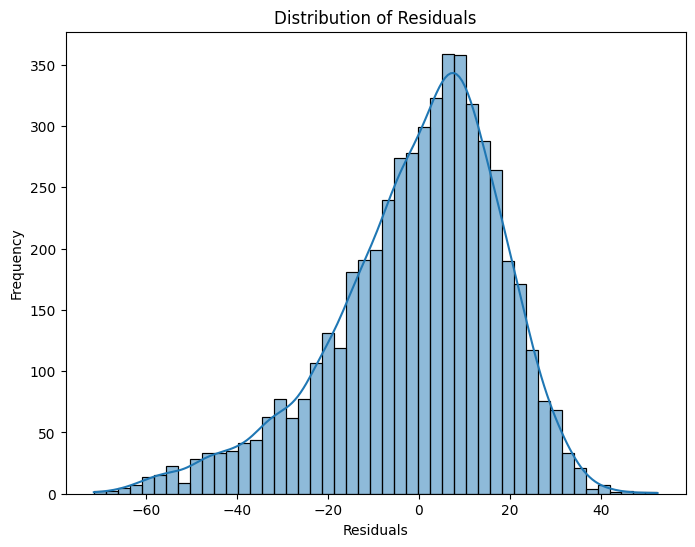

In [ ]:
# Analisis de resultados de una regresion en particular
# De los resultados anteriores se observa que la mejor es ridge_regression usando las detailed_descriptions

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming residuals is calculated as:
residuals = y_test - predictions_ridge

# plot de los residuales
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()



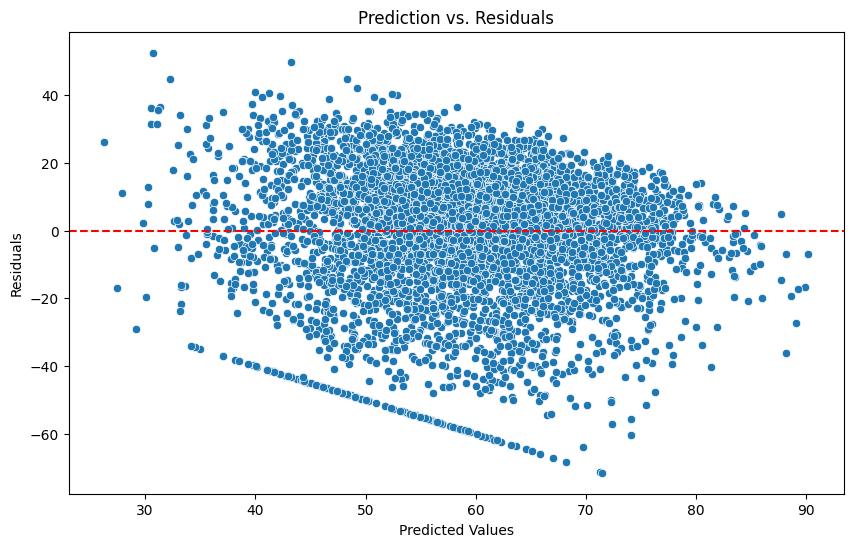

In [ ]:
# Plot de Prediction vs Residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_ridge, y=y_test - predictions_ridge)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Prediction vs. Residuals')
plt.show()


In [ ]:
# Analisis del mejor modelo (Ridge Regression)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients
coefficients = ridge_model.coef_

# Create a DataFrame to display feature names and their corresponding coefficients
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values to see the most important features
feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

# Display the top features
print(feature_importance[0:20])

             Feature  Coefficient
56628   leaderboards    35.563502
34235           even    34.976928
36331       features   -33.009309
28592        discord    29.543668
10344          award    29.423003
53255         jewels   -29.315162
76754         prices   -27.999420
15274          broke   -26.225039
70705       original    25.169134
31465        effects   -24.408622
329              120    24.212908
4100           about    23.966381
15322        brother   -23.937788
87947          shrub   -23.153125
30107          drift   -23.118333
28966        distant   -22.902889
49820             ii    22.888512
17125        careful   -22.727458
104596            ve    22.723893
8838         arsenal    22.128958


In [ ]:
# ANALISIS DE RIDGE REGRESSION:
# A continuación se analiza como mejorar la regresion usando cross-validation para estimar el mejor valor de alpha

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

# Assuming X_train_tfidf and y_train are your training data
alphas = [1.4, 1.5, 1.6]  # Add more alpha values as needed

# Create RidgeCV model with a list of alpha values
ridge_cv_model = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_model.fit(X_train_tfidf, y_train)

# Get the best alpha
best_alpha = ridge_cv_model.alpha_
print(f"Best alpha: {best_alpha}")

# Optional: Print cross-validated performance for each alpha
cv_values = ridge_cv_model.cv_values_
for i, alpha in enumerate(alphas):
    avg_cv_score = np.mean(cv_values[:, i])
    print(f"Cross-validated score for alpha={alpha}: {avg_cv_score}")



Best alpha: 1.5
Cross-validated score for alpha=1.4: 240.37374868255148
Cross-validated score for alpha=1.5: 240.37356254263364
Cross-validated score for alpha=1.6: 240.42402779600104


EJEMPLOS CON JUEGOS FUERA DEL DATASET:

In [ ]:
from tabulate import tabulate

def evaluate_prediction(test_text, real_rating, text_vectorizer, reg_model, n=5):
    # Vectorize the test text
    test_text_vector = text_vectorizer.transform([test_text])

    # Make a prediction using the model
    prediction = reg_model.predict(test_text_vector)

    # Get feature labels (terms) from the TF-IDF vectorizer
    feature_labels = text_vectorizer.get_feature_names_out()

    # Get coefficient values from the Ridge model
    coefficients = reg_model.coef_

    # Get the indices of the non-zero features in the test text
    nonzero_feature_indices = test_text_vector.nonzero()[1]

    # Filter feature labels based on the non-zero features in the test text
    relevant_feature_labels = [feature_labels[i] for i in nonzero_feature_indices]

    # Filter coefficients based on the features present in the test text
    relevant_coefficients = coefficients[nonzero_feature_indices]

    # Sort both lists based on the absolute values of coefficients
    sorted_data = sorted(zip(relevant_coefficients, relevant_feature_labels), key=lambda x: ((x[0])), reverse=False)

    # Take the top n features
    top_n_data = sorted_data[:n]

    # Unpack the top n data into separate lists
    top_n_coefficients, top_n_labels = zip(*top_n_data)

    # Create a table with headers
    table = zip(top_n_coefficients, top_n_labels)
    headers = ["Coefficient", "Feature Label (Words)"]

    # Print the table using tabulate and prediction against real value
    print("Rating Prediction:", str(prediction[0]))
    print("Real Rating Value:", str(real_rating))
    print(" ")
    print("Most negative coefficients:")
    print(tabulate(table, headers=headers, tablefmt="grid"))


In [ ]:
test_text_1=str("Embark on a 3rd person action-adventure quest to avenge the death of your parents at the hands of the ultimate alpha predator: Gaw. Conquer waves of primal beasts and defeat the minions of your arch-nemesis on your way to becoming the rightful King of Skull Island. Traverse the mysterious island and uncover lore and all the secrets the island has to offer as you encounter swamps, waterfalls, jungle, and skullite-filled caves that give the island’s flora and fauna its power Experience the origins of the orphaned Kong as he metamorphosizes from a young Kong to the fully mature King of Skull Island Unleash the combat fury of Kong to deal devastating combos to dominate the ferocious minions of Gaw and tactically unleash rage mode to heighten the impact of your attacks against the island’s gargantuan subterranean denizens Send your enemies running for the hills as you unleash Kong’s spine-tingling roar and deliver their final coup de grace through unique finishing attacks Discover the Mythos of Skull Island as you unearth collectibles, unlock mysterious areas of the island and learn about the history of the islanders, the exotic flora and fauna and the rich history of the Kongs. Ascend Kong to new heights through special events and a variety of boss fights that unlock his full combat potential Leap and Climb mountainous terrain, island vines, swamps, hidden caves, and the various terrain of the jungle-island on your quest to avenge the death of your parents.")
evaluate_prediction(test_text_1, 39.49, tfidf_vectorizer, ridge_model, n=10)

Rating Prediction: 58.75415083780705
Real Rating Value: 39.49
 
Most negative coefficients:
+---------------+-------------------------+
|   Coefficient | Feature Label (Words)   |
+===============+=========================+
|     -21.1363  | various                 |
+---------------+-------------------------+
|     -18.575   | person                  |
+---------------+-------------------------+
|     -16.5263  | history                 |
+---------------+-------------------------+
|     -15.4461  | jungle                  |
+---------------+-------------------------+
|     -14.6015  | king                    |
+---------------+-------------------------+
|     -12.2693  | waves                   |
+---------------+-------------------------+
|     -10.8859  | fury                    |
+---------------+-------------------------+
|     -10.817   | terrain                 |
+---------------+-------------------------+
|     -10.281   | heights                 |
+---------------+-----------